# Install Dependencies

In [13]:
%pip install langchain_openai==0.3.2 langgraph==0.2.68 langchain-community==0.3.16 langchain-experimental==0.3.4 langchain-core==0.3.32 ipython==8.31.0

Note: you may need to restart the kernel to use updated packages.


# Setup Environment

In [14]:
import os

os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')

# Create Tools

In [15]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
        code: Annotated[str, 'The python code to execute to generate your chart.'],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f'Failed to execute. Error: {repr(e)}'
    result_str = f'Successfully executed:\n```python\n{code}\n```\nStdout: {result}'
    return result_str

# Create Agents

In [16]:
from langchain_openai import ChatOpenAI
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END
from langgraph.types import Command

members = ['researcher', 'coder']
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ['FINISH']

system_prompt = (
    'You are a supervisor tasked with managing a conversation between the'
    f' following workers: {members}. Given the following user request,'
    ' respond with the worker to act next. Each worker will perform a'
    ' task and respond with their results and status. When finished,'
    ' respond with FINISH.'
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


llm = ChatOpenAI(model='gpt-4o-mini')


class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members, '__end__']]:
    messages = [
                   {'role': 'system', 'content': system_prompt},
               ] + state['messages']
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response['next']
    if goto == 'FINISH':
        goto = END

    return Command(goto=goto, update={'next': goto})

# Build Graph

In [17]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
    llm, tools=[tavily_tool], prompt='You are a researcher. DO NOT do any math.'
)


def research_node(state: State) -> Command[Literal['supervisor']]:
    result = research_agent.invoke(state)
    return Command(
        update={
            'messages': [
                HumanMessage(content=result['messages'][-1].content, name='researcher')
            ]
        },
        goto='supervisor',
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: State) -> Command[Literal['supervisor']]:
    result = code_agent.invoke(state)
    return Command(
        update={
            'messages': [
                HumanMessage(content=result['messages'][-1].content, name='coder')
            ]
        },
        goto='supervisor',
    )


builder = StateGraph(State)
builder.add_edge(START, 'supervisor')
builder.add_node('supervisor', supervisor_node)
builder.add_node('researcher', research_node)
builder.add_node('coder', code_node)
graph = builder.compile()

# Graph

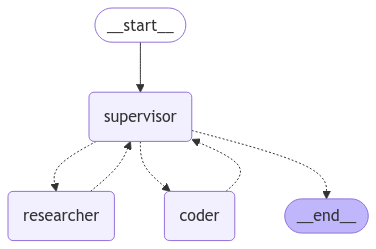

In [18]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

# Test

In [19]:
for s in graph.stream(
        {"messages": [("user", "What's the square root of 42?")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:ad48e061-94df-efbf-00b9-7e45460b0382',), {'agent': {'messages': [AIMessage(content="I can't perform calculations, but I can help you with other information or queries related to the square root of 42. Let me know what you need!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 98, 'total_tokens': 131, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63', 'finish_reason': 'stop', 'logprobs': None}, id='run-0fc62dad-cb2e-482d-90ba-c632c949990a-0', usage_metadata={'input_tokens': 98, 'output_tokens': 33, 'total_tokens': 131, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}

In [20]:
for s in graph.stream(
        {
            "messages": [
                (
                        "user",
                        "Find the latest GDP of New York and California, then calculate the average",
                )
            ]
        },
        subgraphs=True,
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:197416f0-e660-fe3f-c551-703174653c18',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_uJAfudDKIlLgKAgguHSHR4ZQ', 'function': {'arguments': '{"query": "latest GDP of New York 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_Bh5xHf6gg39Is2NW0sOH3RLm', 'function': {'arguments': '{"query": "latest GDP of California 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 104, 'total_tokens': 170, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1e7b7b64